In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pickle
import itertools
import tqdm
from src.mlmodel import *
import src.utils as utils
from ZSTL_GPU import ZSTL

In [2]:
net = FuncRecursiveNet([
    FLinearLayer(1, False)
])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
torch.exp(torch.tensor(50.))

tensor(5.1847e+21)

In [4]:
d = 8
dm = 5
T = 200
n = 20
dict_k = 6
shape_record = {}
shape_record[0] = [(1,d)]

def synthetic_binClass(d, dm, dict_k, T, n, random_state = 110):
    np.random.seed(110)
    L_gt = np.random.randn(d,dict_k)

    D_gt = np.random.randn(dm,dict_k)

    s = np.random.uniform(0, 2, size=(dict_k, T))
    s[s>=1] = 0

    ones = np.atleast_2d(np.ones(n))
    x = np.random.normal(0, 1.0, size=(d-1,n))*2
    x = np.vstack((ones, x))

    w = L_gt @ s
    a = D_gt @ s

    y = utils.sigmoid(w.T @ x)
    y[y >=0.5] = np.ones_like(y[y >=0.5])
    y[y <0.5] = np.zeros_like(y[y < 0.5])

    print('y ', np.sum(y, axis=1))

    a = a.T
    w = w.T
    x = x.T

    dataset = [(a[t,:], np.expand_dims(w[t,:], axis=0), x, np.expand_dims(y[t,:], axis=1)) for t in range(T)]

    print(a[1,:].shape, w[1,:].shape, x.shape, y[1,:].shape)
    return dataset

dataset = synthetic_binClass(d, dm, dict_k, T, n, random_state = 999)
print('len dataset ', len(dataset))
kb_size = 10
train_size = 140
total_len = len(dataset)
test_size = total_len - kb_size - train_size

indx = [ x for x in range(len(dataset))]
support_indx = list(np.random.choice(indx, size=kb_size, replace=False))
print(len(support_indx))
temp = [x for x in indx if x not in support_indx]
train_indx = list(np.random.choice(temp, size=train_size, replace=False))
temp = [x for x in temp if x not in train_indx]
print(len(train_indx))
test_indx = temp
print(len(test_indx))


support_data = utils.Dataset([dataset[d] for d in support_indx])
train_data = utils.Dataset([dataset[d] for d in train_indx])
test_data = utils.Dataset([dataset[d] for d in test_indx])

support_loader = DataLoader(support_data, batch_size=kb_size, shuffle=False)
train_loader = DataLoader(train_data, batch_size=train_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_size, shuffle=True)
train_a, train_w, train_x, train_y = next(iter(train_loader))
train_a, train_w, train_x, train_y = train_a.float(), train_w.float(), train_x.float(), train_y.float()
print(train_a.shape, train_w.shape, train_x.shape, train_y.shape)

y  [12. 13. 17. 11.  7. 11. 11. 10.  8. 11. 11. 11. 11. 12. 17. 14. 15. 12.
 11.  8. 10. 14. 17. 17. 11. 16. 10. 10. 11. 12. 11. 11. 12. 16. 12. 11.
 11. 14. 14. 12. 17. 17.  9. 14. 11. 11. 12. 11. 13. 13. 10. 12. 12. 11.
 14. 16. 17. 14. 16. 13. 11. 15. 12. 12. 14. 15. 14. 16. 13. 13. 10. 13.
  9. 12. 10. 12. 12. 14. 10. 17. 11.  9. 11. 11. 10. 11. 14.  7. 12. 13.
 14. 12. 12. 11. 15. 15. 14. 13. 10. 14. 11. 11. 14. 16. 12. 17. 15. 12.
 13. 14. 11. 11. 20. 12. 11. 12. 14. 13. 12. 11. 12. 11. 11. 13. 14. 17.
 13. 12. 17. 12. 13. 16. 15.  7. 13. 13. 12. 11. 10. 16. 11. 11.  8. 10.
 13. 14.  9. 13.  8. 13. 20. 11. 10. 12. 11. 14. 11. 11. 11.  8.  9. 15.
 12. 14. 12. 12. 10. 14. 14. 13. 11. 10. 11. 13. 12. 14. 17. 17.  8. 16.
 11.  7. 14. 14. 13. 12. 11. 12. 15. 10. 14. 11. 12. 14. 11. 10. 14. 12.
 11. 11.]
(5,) (8,) (20, 8) (20,)
len dataset  200
10
140
50
torch.Size([140, 1, 5]) torch.Size([140, 1, 8]) torch.Size([140, 20, 8]) torch.Size([140, 20, 1])


5
{'rho': 1e-05, 'mu': 1e-05, 'loss': 'binary class', 'outer lr': 0.001, 'align lr': 0.0001, 'dm': 5, 'd': 8, 'model_shape': {0: [(1, 8)]}, 'atten_activation': 'Sparsemax'}
test  torch.Size([5, 50]) torch.Size([8, 50]) torch.Size([50, 20, 8]) torch.Size([50, 20, 1])
weight_kb  torch.Size([8, 10])
init mean test metric 0.81; align loss 0.01304323785007
1/1000 o_loss 0.4940635482132036; m train metric 0.8135714285714286; m test metric 0.81; align loss  0.012628750875592232
200/1000 o_loss 0.30857506709206584; m train metric 0.8728571428571429; m test metric 0.866; align loss  0.00955063384026289
400/1000 o_loss 0.27498518012331; m train metric 0.8857142857142863; m test metric 0.8819999999999999; align loss  0.009715593419969082
600/1000 o_loss 0.25905627284332045; m train metric 0.8967857142857151; m test metric 0.889; align loss  0.010360389947891235
800/1000 o_loss 0.2485587590906237; m train metric 0.9010714285714292; m test metric 0.8990000000000002; align loss  0.011802026070654392

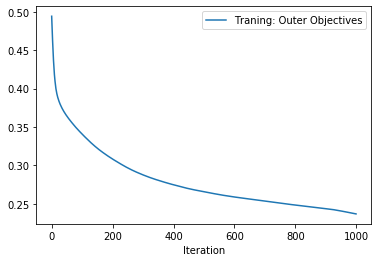

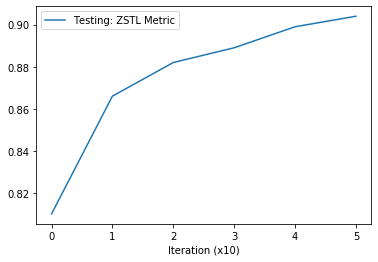

0

In [5]:
support_a, support_w, support_x, support_y = next(iter(support_loader))
support_a, support_w, support_x, support_y = support_a.float(), support_w.float(), support_x.float(), support_y.float()
support_a = support_a.squeeze().t()
support_w = support_w.squeeze().t()
dm = support_a.size()[0]
print(dm)

param_dict = {}
param_dict['rho'] = 1e-5
param_dict['mu'] = 1e-5
param_dict['loss'] = 'binary class'
param_dict['outer lr'] = 1e-3
param_dict['align lr'] = 1e-4
param_dict['dm'] = dm
param_dict['d'] = d
param_dict['model_shape'] = shape_record
param_dict['atten_activation'] = 'Sparsemax'
print(param_dict)


ZSTL_model = ZSTL(support_w, support_a, net, param_dict, device)
ZSTL_model.train(train_loader, test_loader, max_iter=1000)

5
8
20
120
120
20
num of hp  25
rho for w_kb 0.1; mu for a_kb 0.1;
softmax selected
test  torch.Size([5, 20]) torch.Size([8, 20]) torch.Size([20, 20, 8]) torch.Size([20, 20, 1])
weight_kb  torch.Size([8, 10])
init mean test metric 0.7949999999999999; align loss 4.925884246826172
1/1500 o_loss 6.115371505046884; m train metric 0.8166666666666667; m test metric 0.7949999999999999; align loss  0.014001846313476562
100/1500 o_loss 5.098065766319633; m train metric 0.8258333333333336; m test metric 0.7949999999999998; align loss  0.01141500473022461
200/1500 o_loss 4.308187714777887; m train metric 0.8320833333333336; m test metric 0.7974999999999998; align loss  0.011311531066894531
300/1500 o_loss 3.67620286171635; m train metric 0.8325000000000007; m test metric 0.8049999999999999; align loss  0.011760711669921875
400/1500 o_loss 3.161316172561298; m train metric 0.8341666666666668; m test metric 0.8024999999999999; align loss  0.012325763702392578
500/1500 o_loss 2.737467757364114; m tr

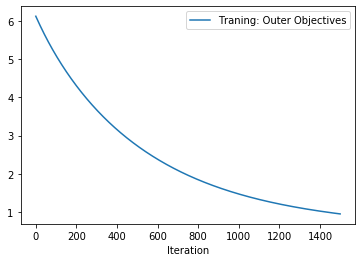

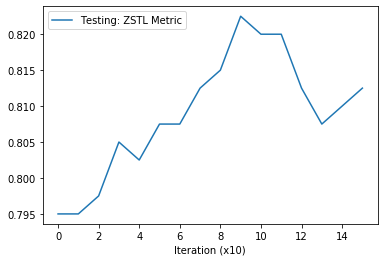

mean metric 0.8125
New best acc 0.8125
rho for w_kb 0.1; mu for a_kb 0.01;
softmax selected
test  torch.Size([5, 20]) torch.Size([8, 20]) torch.Size([20, 20, 8]) torch.Size([20, 20, 1])
weight_kb  torch.Size([8, 10])
init mean test metric 0.7949999999999999; align loss 0.5044783353805542
1/1500 o_loss 6.115371505046884; m train metric 0.8166666666666665; m test metric 0.7949999999999999; align loss  0.01331394910812378
100/1500 o_loss 5.098065768741071; m train metric 0.8258333333333332; m test metric 0.795; align loss  0.010738641023635864
200/1500 o_loss 4.308187716826796; m train metric 0.832083333333334; m test metric 0.7975000000000001; align loss  0.010649263858795166
300/1500 o_loss 3.6762028660314776; m train metric 0.8325000000000004; m test metric 0.805; align loss  0.011109650135040283
400/1500 o_loss 3.1613161714437106; m train metric 0.834166666666667; m test metric 0.8025; align loss  0.011685460805892944
500/1500 o_loss 2.7374677567742767; m train metric 0.83833333333333

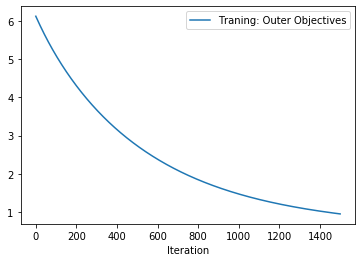

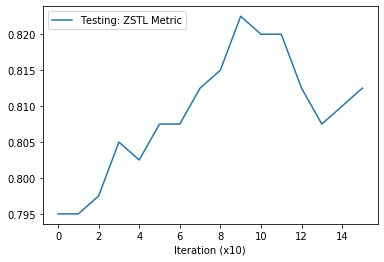

mean metric 0.8125
New best acc 0.8125
rho for w_kb 0.1; mu for a_kb 0.001;
softmax selected
test  torch.Size([5, 20]) torch.Size([8, 20]) torch.Size([20, 20, 8]) torch.Size([20, 20, 1])
weight_kb  torch.Size([8, 10])
init mean test metric 0.7949999999999999; align loss 0.06233779340982437
1/1500 o_loss 6.115371505046884; m train metric 0.8166666666666672; m test metric 0.7949999999999999; align loss  0.013245157897472382
100/1500 o_loss 5.098065769299865; m train metric 0.8258333333333333; m test metric 0.7949999999999999; align loss  0.010671045631170273
200/1500 o_loss 4.308187717323502; m train metric 0.8320833333333337; m test metric 0.7975; align loss  0.010583054274320602
300/1500 o_loss 3.6762028604745867; m train metric 0.8325000000000007; m test metric 0.805; align loss  0.01104457676410675
400/1500 o_loss 3.161316168991228; m train metric 0.8341666666666671; m test metric 0.8025; align loss  0.011621367186307907
500/1500 o_loss 2.7374677515899144; m train metric 0.8383333333

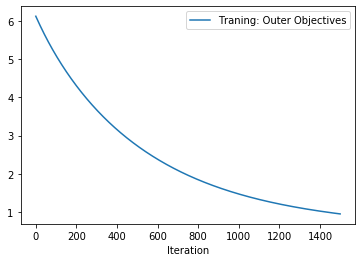

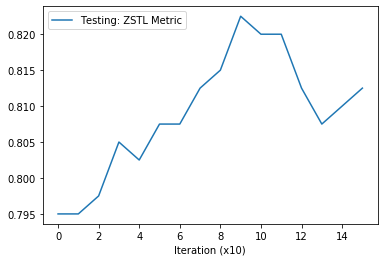

mean metric 0.8125
New best acc 0.8125
rho for w_kb 0.1; mu for a_kb 0.0001;
softmax selected
test  torch.Size([5, 20]) torch.Size([8, 20]) torch.Size([20, 20, 8]) torch.Size([20, 20, 1])
weight_kb  torch.Size([8, 10])
init mean test metric 0.7949999999999999; align loss 0.01812373846769333
1/1500 o_loss 6.115371505046884; m train metric 0.8166666666666668; m test metric 0.7949999999999999; align loss  0.01323828287422657
100/1500 o_loss 5.0980657874296105; m train metric 0.8258333333333338; m test metric 0.795; align loss  0.01066429540514946
200/1500 o_loss 4.308187687707444; m train metric 0.8320833333333338; m test metric 0.7975; align loss  0.010576451197266579
300/1500 o_loss 3.6762028288717072; m train metric 0.8325000000000002; m test metric 0.8049999999999999; align loss  0.011038091965019703
400/1500 o_loss 3.161316606712838; m train metric 0.834166666666667; m test metric 0.8025; align loss  0.011615000665187836
500/1500 o_loss 2.7374672315704327; m train metric 0.8383333333

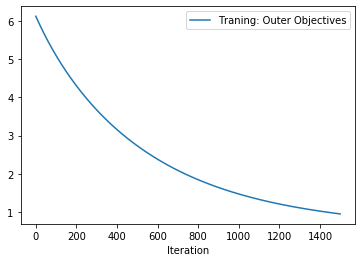

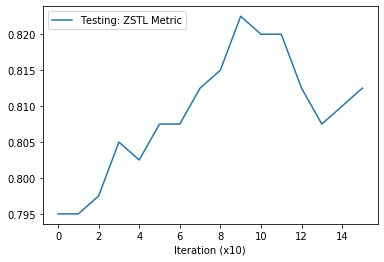

mean metric 0.8125
New best acc 0.8125
rho for w_kb 0.1; mu for a_kb 1e-05;
softmax selected
test  torch.Size([5, 20]) torch.Size([8, 20]) torch.Size([20, 20, 8]) torch.Size([20, 20, 1])
weight_kb  torch.Size([8, 10])
init mean test metric 0.7949999999999999; align loss 0.013702332973480225
1/1500 o_loss 6.115371505046884; m train metric 0.8166666666666665; m test metric 0.7949999999999999; align loss  0.01323759462684393
100/1500 o_loss 5.0980659093086915; m train metric 0.8258333333333336; m test metric 0.795; align loss  0.010663664899766445
200/1500 o_loss 4.3081879256914055; m train metric 0.8320833333333337; m test metric 0.7975; align loss  0.010575929656624794
300/1500 o_loss 3.6762024716474118; m train metric 0.8325000000000009; m test metric 0.805; align loss  0.011037713848054409
400/1500 o_loss 3.1613162129806973; m train metric 0.8341666666666671; m test metric 0.8025; align loss  0.011614741757512093
500/1500 o_loss 2.737467754756411; m train metric 0.8383333333333334; m 

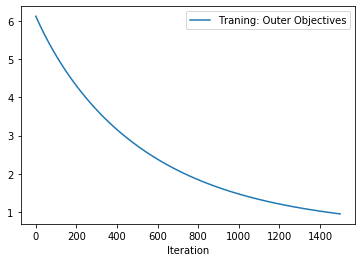

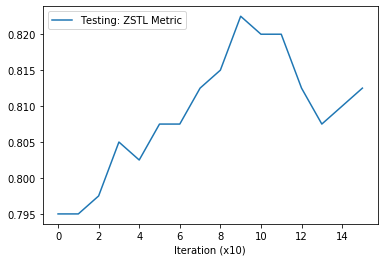

mean metric 0.8125
New best acc 0.8125
rho for w_kb 0.01; mu for a_kb 0.1;
softmax selected
test  torch.Size([5, 20]) torch.Size([8, 20]) torch.Size([20, 20, 8]) torch.Size([20, 20, 1])
weight_kb  torch.Size([8, 10])
init mean test metric 0.795; align loss 4.925884246826172
1/1500 o_loss 1.0529302752266327; m train metric 0.8166666666666667; m test metric 0.795; align loss  0.01400136947631836
100/1500 o_loss 0.8738271610190471; m train metric 0.8304166666666668; m test metric 0.7949999999999998; align loss  0.011137008666992188
200/1500 o_loss 0.7724928679565588; m train metric 0.840000000000001; m test metric 0.8099999999999999; align loss  0.010762691497802734
300/1500 o_loss 0.7004766124300659; m train metric 0.844166666666667; m test metric 0.8150000000000001; align loss  0.011118412017822266
400/1500 o_loss 0.6450844634324312; m train metric 0.8466666666666671; m test metric 0.8225; align loss  0.01166677474975586
500/1500 o_loss 0.6013395759897928; m train metric 0.8487500000000

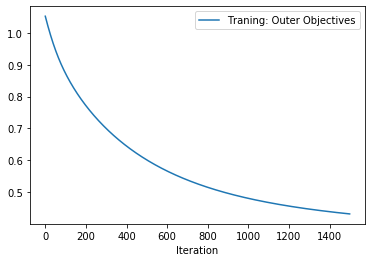

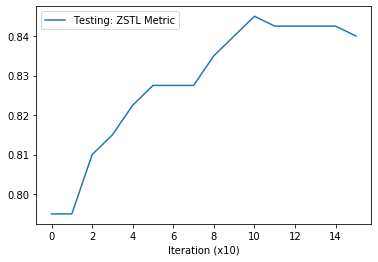

mean metric 0.8400000000000001
New best acc 0.8400000000000001
rho for w_kb 0.01; mu for a_kb 0.01;
softmax selected
test  torch.Size([5, 20]) torch.Size([8, 20]) torch.Size([20, 20, 8]) torch.Size([20, 20, 1])
weight_kb  torch.Size([8, 10])
init mean test metric 0.7949999999999999; align loss 0.5044783353805542
1/1500 o_loss 1.0529302752266327; m train metric 0.8166666666666668; m test metric 0.7949999999999999; align loss  0.013313233852386475
100/1500 o_loss 0.8738271857301394; m train metric 0.8304166666666666; m test metric 0.795; align loss  0.010460704565048218
200/1500 o_loss 0.7724928701917331; m train metric 0.8400000000000004; m test metric 0.8099999999999999; align loss  0.010100573301315308
300/1500 o_loss 0.7004766128646831; m train metric 0.8441666666666668; m test metric 0.8150000000000001; align loss  0.01046726107597351
400/1500 o_loss 0.6450844596760968; m train metric 0.8466666666666669; m test metric 0.8225000000000001; align loss  0.011026591062545776
500/1500 o_l

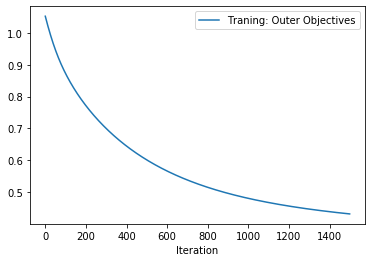

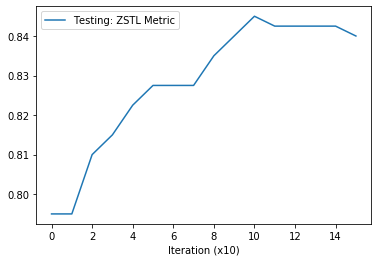

mean metric 0.8400000000000001
New best acc 0.8400000000000001
rho for w_kb 0.01; mu for a_kb 0.001;
softmax selected
test  torch.Size([5, 20]) torch.Size([8, 20]) torch.Size([20, 20, 8]) torch.Size([20, 20, 1])
weight_kb  torch.Size([8, 10])
init mean test metric 0.7949999999999999; align loss 0.06233779340982437
1/1500 o_loss 1.0529302752266327; m train metric 0.816666666666667; m test metric 0.7949999999999999; align loss  0.013244438916444778
100/1500 o_loss 0.8738271553069353; m train metric 0.8304166666666666; m test metric 0.7949999999999999; align loss  0.010393097996711731
200/1500 o_loss 0.7724928677702944; m train metric 0.8400000000000006; m test metric 0.8099999999999999; align loss  0.010034333914518356
300/1500 o_loss 0.7004765455921491; m train metric 0.844166666666667; m test metric 0.8150000000000001; align loss  0.010402187705039978
400/1500 o_loss 0.6450844527532658; m train metric 0.8466666666666672; m test metric 0.8225; align loss  0.010962504893541336
500/1500 o

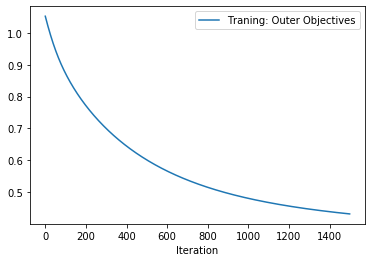

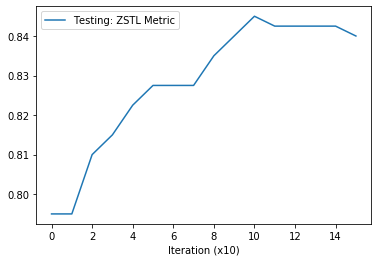

mean metric 0.8399999999999999
rho for w_kb 0.01; mu for a_kb 0.0001;
softmax selected
test  torch.Size([5, 20]) torch.Size([8, 20]) torch.Size([20, 20, 8]) torch.Size([20, 20, 1])
weight_kb  torch.Size([8, 10])
init mean test metric 0.7949999999999999; align loss 0.01812373846769333
1/1500 o_loss 1.0529302752266327; m train metric 0.8166666666666667; m test metric 0.7949999999999999; align loss  0.013237560167908669
100/1500 o_loss 0.8738271699597437; m train metric 0.830416666666667; m test metric 0.7949999999999997; align loss  0.010386347770690918
200/1500 o_loss 0.7724928436179956; m train metric 0.8400000000000004; m test metric 0.8099999999999998; align loss  0.010027730837464333
300/1500 o_loss 0.7004765560850501; m train metric 0.844166666666667; m test metric 0.8149999999999998; align loss  0.01039570290595293
400/1500 o_loss 0.6450843787441651; m train metric 0.8466666666666666; m test metric 0.8225; align loss  0.010956138372421265
500/1500 o_loss 0.6013395123183727; m trai

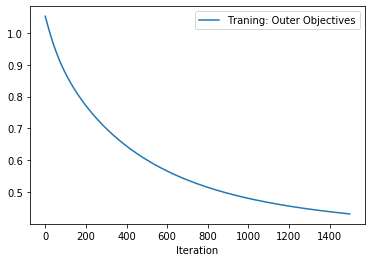

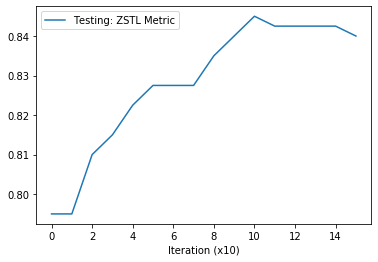

mean metric 0.8400000000000001
New best acc 0.8400000000000001
rho for w_kb 0.01; mu for a_kb 1e-05;
softmax selected
test  torch.Size([5, 20]) torch.Size([8, 20]) torch.Size([20, 20, 8]) torch.Size([20, 20, 1])
weight_kb  torch.Size([8, 10])
init mean test metric 0.795; align loss 0.0137023339048028
1/1500 o_loss 1.0529302752266327; m train metric 0.816666666666667; m test metric 0.795; align loss  0.013236872851848602
100/1500 o_loss 0.8738272478183111; m train metric 0.8304166666666671; m test metric 0.795; align loss  0.010385711677372456
200/1500 o_loss 0.7724927259609103; m train metric 0.8400000000000004; m test metric 0.8099999999999998; align loss  0.010027199983596802
300/1500 o_loss 0.700476314065357; m train metric 0.844166666666667; m test metric 0.8149999999999998; align loss  0.010395318269729614
400/1500 o_loss 0.6450838133692741; m train metric 0.846666666666667; m test metric 0.8225; align loss  0.010955876670777798
500/1500 o_loss 0.6013387284241617; m train metric 0

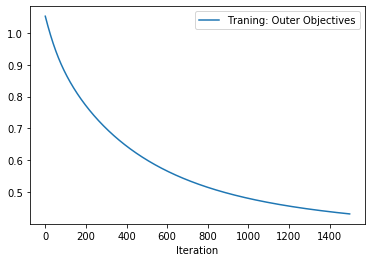

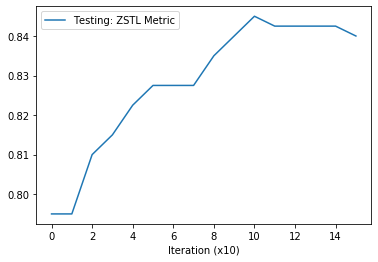

mean metric 0.8400000000000001
New best acc 0.8400000000000001
rho for w_kb 0.001; mu for a_kb 0.1;
softmax selected
test  torch.Size([5, 20]) torch.Size([8, 20]) torch.Size([20, 20, 8]) torch.Size([20, 20, 1])
weight_kb  torch.Size([8, 10])
init mean test metric 0.795; align loss 4.925884246826172
1/1500 o_loss 0.5466861783216397; m train metric 0.8166666666666669; m test metric 0.795; align loss  0.014004230499267578
100/1500 o_loss 0.43727733604609964; m train metric 0.8325000000000007; m test metric 0.8074999999999999; align loss  0.010658740997314453
200/1500 o_loss 0.40184506016472976; m train metric 0.85; m test metric 0.8225; align loss  0.009458541870117188
300/1500 o_loss 0.3837480099250873; m train metric 0.8537500000000003; m test metric 0.8300000000000001; align loss  0.00891256332397461
400/1500 o_loss 0.37095740661025045; m train metric 0.8558333333333333; m test metric 0.8400000000000001; align loss  0.00849771499633789
500/1500 o_loss 0.36116107453902563; m train metri

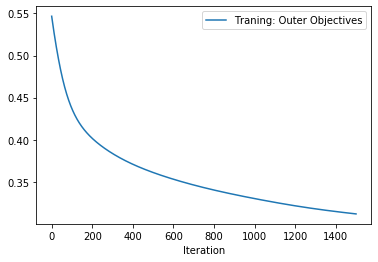

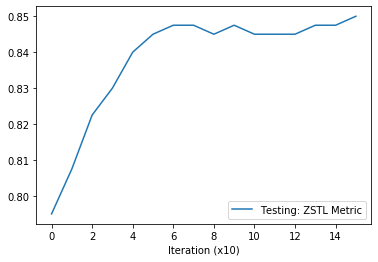

mean metric 0.8499999999999999
New best acc 0.8499999999999999
rho for w_kb 0.001; mu for a_kb 0.01;
softmax selected
test  torch.Size([5, 20]) torch.Size([8, 20]) torch.Size([20, 20, 8]) torch.Size([20, 20, 1])
weight_kb  torch.Size([8, 10])
init mean test metric 0.7949999999999999; align loss 0.5044783353805542
1/1500 o_loss 0.5466861783216397; m train metric 0.8166666666666669; m test metric 0.7949999999999999; align loss  0.013316333293914795
100/1500 o_loss 0.43727733865380286; m train metric 0.8325000000000004; m test metric 0.8074999999999999; align loss  0.009982377290725708
200/1500 o_loss 0.40184506041308243; m train metric 0.8500000000000002; m test metric 0.8224999999999998; align loss  0.008796215057373047
300/1500 o_loss 0.38374800930420555; m train metric 0.8537500000000001; m test metric 0.8299999999999997; align loss  0.008261293172836304
400/1500 o_loss 0.37095740443716446; m train metric 0.8558333333333336; m test metric 0.8399999999999999; align loss  0.007857471704

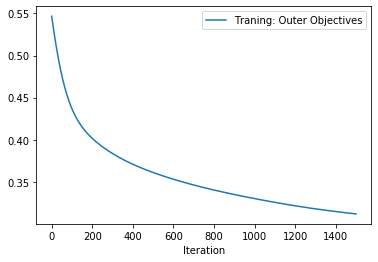

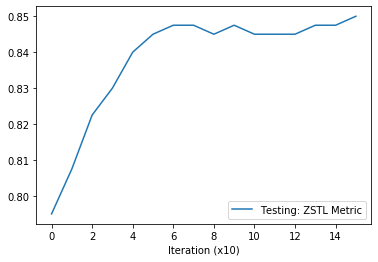

mean metric 0.8499999999999999
New best acc 0.8499999999999999
rho for w_kb 0.001; mu for a_kb 0.001;
softmax selected
test  torch.Size([5, 20]) torch.Size([8, 20]) torch.Size([20, 20, 8]) torch.Size([20, 20, 1])
weight_kb  torch.Size([8, 10])
init mean test metric 0.7949999999999999; align loss 0.06233779340982437
1/1500 o_loss 0.5466861783216397; m train metric 0.8166666666666669; m test metric 0.7949999999999999; align loss  0.013247538357973099
100/1500 o_loss 0.4372773344318072; m train metric 0.8325000000000004; m test metric 0.8074999999999999; align loss  0.009914789348840714
200/1500 o_loss 0.4018450600405534; m train metric 0.8500000000000003; m test metric 0.8224999999999998; align loss  0.008729975670576096
300/1500 o_loss 0.3837480024124185; m train metric 0.8537500000000003; m test metric 0.8299999999999998; align loss  0.008196219801902771
400/1500 o_loss 0.3709573940684398; m train metric 0.8558333333333334; m test metric 0.8399999999999999; align loss  0.00779337435960

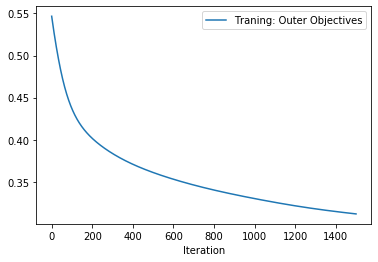

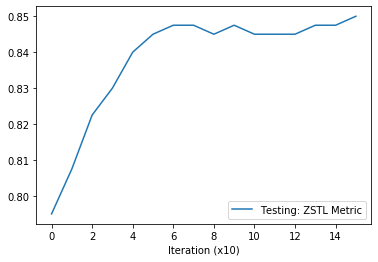

mean metric 0.8499999999999999
New best acc 0.8499999999999999
rho for w_kb 0.001; mu for a_kb 0.0001;
softmax selected
test  torch.Size([5, 20]) torch.Size([8, 20]) torch.Size([20, 20, 8]) torch.Size([20, 20, 1])
weight_kb  torch.Size([8, 10])
init mean test metric 0.7949999999999999; align loss 0.01812373846769333
1/1500 o_loss 0.5466861783216397; m train metric 0.8166666666666667; m test metric 0.7949999999999999; align loss  0.013240659609436989
100/1500 o_loss 0.4372773513197899; m train metric 0.8325000000000004; m test metric 0.8074999999999999; align loss  0.009908042848110199
200/1500 o_loss 0.40184504706412555; m train metric 0.8500000000000001; m test metric 0.8224999999999998; align loss  0.008723370730876923
300/1500 o_loss 0.38374796075125533; m train metric 0.8537500000000002; m test metric 0.8299999999999997; align loss  0.008189729414880276
400/1500 o_loss 0.37095733179400364; m train metric 0.8558333333333337; m test metric 0.8399999999999999; align loss  0.0077869985

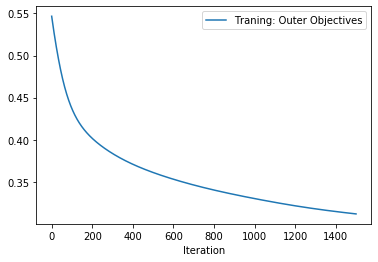

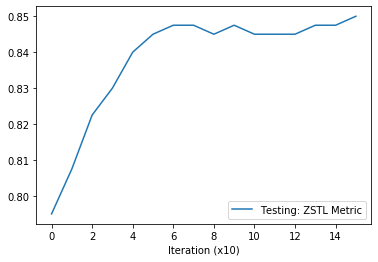

mean metric 0.8499999999999999
New best acc 0.8499999999999999
rho for w_kb 0.001; mu for a_kb 1e-05;
softmax selected
test  torch.Size([5, 20]) torch.Size([8, 20]) torch.Size([20, 20, 8]) torch.Size([20, 20, 1])
weight_kb  torch.Size([8, 10])
init mean test metric 0.795; align loss 0.013702332973480225
1/1500 o_loss 0.5466861783216397; m train metric 0.8166666666666662; m test metric 0.795; align loss  0.013239972293376923
100/1500 o_loss 0.4372774406025807; m train metric 0.8325000000000007; m test metric 0.8074999999999999; align loss  0.009907416068017483
200/1500 o_loss 0.40184486073752246; m train metric 0.8500000000000002; m test metric 0.8224999999999998; align loss  0.008722823113203049
300/1500 o_loss 0.3837475568056107; m train metric 0.8537499999999998; m test metric 0.8299999999999998; align loss  0.008189281448721886
400/1500 o_loss 0.37095673798273004; m train metric 0.8558333333333337; m test metric 0.8399999999999999; align loss  0.007786632049828768
500/1500 o_loss 0.

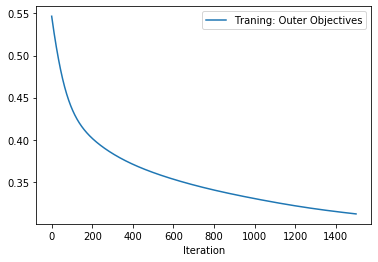

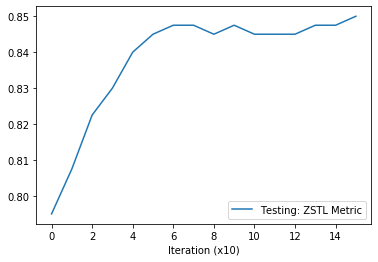

mean metric 0.8499999999999999
New best acc 0.8499999999999999
rho for w_kb 0.0001; mu for a_kb 0.1;
softmax selected
test  torch.Size([5, 20]) torch.Size([8, 20]) torch.Size([20, 20, 8]) torch.Size([20, 20, 1])
weight_kb  torch.Size([8, 10])
init mean test metric 0.795; align loss 4.925884246826172
1/1500 o_loss 0.49606176583717265; m train metric 0.8166666666666669; m test metric 0.795; align loss  0.014005661010742188
100/1500 o_loss 0.38853082082544765; m train metric 0.8325000000000001; m test metric 0.805; align loss  0.010469913482666016
200/1500 o_loss 0.3543689529101054; m train metric 0.850833333333334; m test metric 0.825; align loss  0.00951385498046875
300/1500 o_loss 0.33800899650280675; m train metric 0.8570833333333336; m test metric 0.8300000000000001; align loss  0.009430408477783203
400/1500 o_loss 0.32657935839767255; m train metric 0.8620833333333336; m test metric 0.8425; align loss  0.009530067443847656
500/1500 o_loss 0.3176197392555575; m train metric 0.8637500

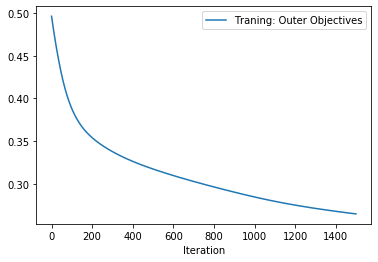

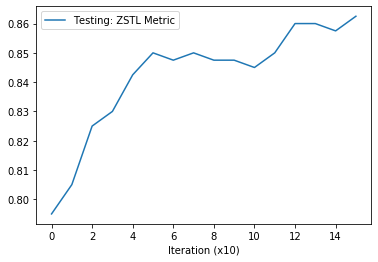

mean metric 0.8625
New best acc 0.8625
rho for w_kb 0.0001; mu for a_kb 0.01;
softmax selected
test  torch.Size([5, 20]) torch.Size([8, 20]) torch.Size([20, 20, 8]) torch.Size([20, 20, 1])
weight_kb  torch.Size([8, 10])
init mean test metric 0.795; align loss 0.5044783353805542
1/1500 o_loss 0.49606176583717265; m train metric 0.8166666666666668; m test metric 0.795; align loss  0.013317644596099854
100/1500 o_loss 0.38853082281226914; m train metric 0.8325000000000002; m test metric 0.805; align loss  0.00979343056678772
200/1500 o_loss 0.35436895011613767; m train metric 0.8508333333333334; m test metric 0.825; align loss  0.008851617574691772
300/1500 o_loss 0.33800899240498744; m train metric 0.8570833333333335; m test metric 0.8300000000000001; align loss  0.008779436349868774
400/1500 o_loss 0.32657935625563067; m train metric 0.8620833333333334; m test metric 0.8424999999999999; align loss  0.008889913558959961
500/1500 o_loss 0.31761973357448975; m train metric 0.86375000000000

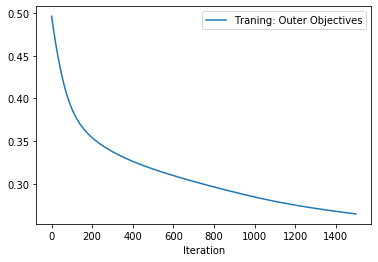

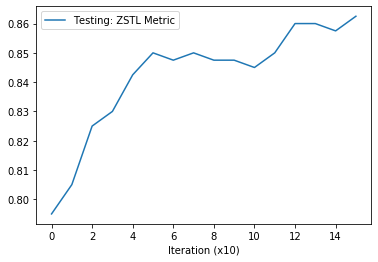

mean metric 0.8625
New best acc 0.8625
rho for w_kb 0.0001; mu for a_kb 0.001;
softmax selected
test  torch.Size([5, 20]) torch.Size([8, 20]) torch.Size([20, 20, 8]) torch.Size([20, 20, 1])
weight_kb  torch.Size([8, 10])
init mean test metric 0.795; align loss 0.06233779713511467
1/1500 o_loss 0.49606176583717265; m train metric 0.8166666666666669; m test metric 0.795; align loss  0.013248898088932037
100/1500 o_loss 0.38853082628920677; m train metric 0.8325000000000001; m test metric 0.805; align loss  0.009725835174322128
200/1500 o_loss 0.35436894508699573; m train metric 0.8508333333333334; m test metric 0.825; align loss  0.008785385638475418
300/1500 o_loss 0.3380089888970057; m train metric 0.8570833333333335; m test metric 0.8299999999999998; align loss  0.008714359253644943
400/1500 o_loss 0.32657934554542106; m train metric 0.8620833333333333; m test metric 0.8425; align loss  0.008825838565826416
500/1500 o_loss 0.31761972131207583; m train metric 0.8637500000000007; m test

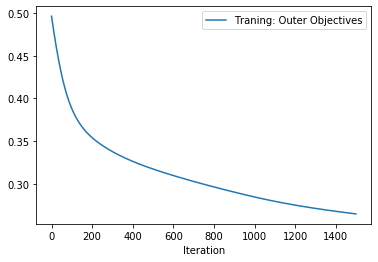

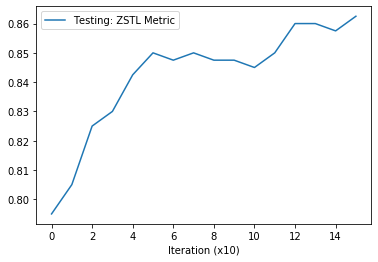

mean metric 0.8624999999999998
rho for w_kb 0.0001; mu for a_kb 0.0001;
softmax selected
test  torch.Size([5, 20]) torch.Size([8, 20]) torch.Size([20, 20, 8]) torch.Size([20, 20, 1])
weight_kb  torch.Size([8, 10])
init mean test metric 0.7950000000000002; align loss 0.01812373846769333
1/1500 o_loss 0.49606176583717265; m train metric 0.8166666666666662; m test metric 0.7950000000000002; align loss  0.013242019340395927
100/1500 o_loss 0.38853084106619157; m train metric 0.8325000000000004; m test metric 0.8049999999999999; align loss  0.009719086810946465
200/1500 o_loss 0.35436892552922167; m train metric 0.8508333333333337; m test metric 0.825; align loss  0.008778776973485947
300/1500 o_loss 0.3380089409649372; m train metric 0.8570833333333333; m test metric 0.8299999999999998; align loss  0.00870786514133215
400/1500 o_loss 0.3265792651101947; m train metric 0.8620833333333331; m test metric 0.8425; align loss  0.0088194590061903
500/1500 o_loss 0.31761961337178946; m train metri

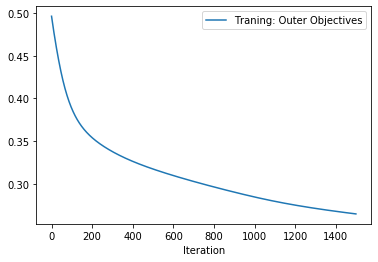

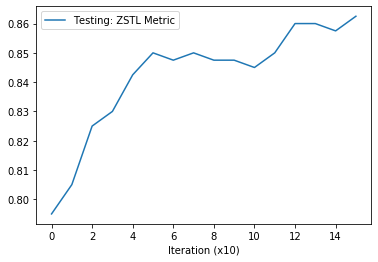

mean metric 0.8625
New best acc 0.8625
rho for w_kb 0.0001; mu for a_kb 1e-05;
softmax selected
test  torch.Size([5, 20]) torch.Size([8, 20]) torch.Size([20, 20, 8]) torch.Size([20, 20, 1])
weight_kb  torch.Size([8, 10])
init mean test metric 0.7949999999999998; align loss 0.013702332973480225
1/1500 o_loss 0.49606176583717265; m train metric 0.8166666666666665; m test metric 0.7949999999999998; align loss  0.013241332955658436
100/1500 o_loss 0.3885309572952489; m train metric 0.8325000000000001; m test metric 0.8049999999999999; align loss  0.009718470275402069
200/1500 o_loss 0.3543687595054507; m train metric 0.8508333333333333; m test metric 0.8249999999999998; align loss  0.008778240531682968
300/1500 o_loss 0.3380085116562744; m train metric 0.8570833333333336; m test metric 0.8299999999999998; align loss  0.00870739109814167
400/1500 o_loss 0.3265785425590972; m train metric 0.8620833333333334; m test metric 0.8425; align loss  0.00881902500987053
500/1500 o_loss 0.317618527760

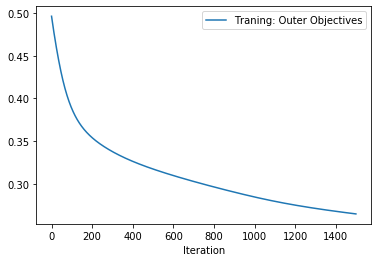

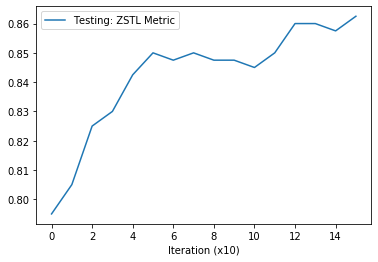

mean metric 0.8624999999999998
rho for w_kb 1e-05; mu for a_kb 0.1;
softmax selected
test  torch.Size([5, 20]) torch.Size([8, 20]) torch.Size([20, 20, 8]) torch.Size([20, 20, 1])
weight_kb  torch.Size([8, 10])
init mean test metric 0.7950000000000002; align loss 4.925884246826172
1/1500 o_loss 0.49099932513587796; m train metric 0.8166666666666667; m test metric 0.7950000000000002; align loss  0.01400613784790039
100/1500 o_loss 0.383418156800326; m train metric 0.8329166666666669; m test metric 0.8049999999999999; align loss  0.010426998138427734
200/1500 o_loss 0.34919086668329935; m train metric 0.8508333333333336; m test metric 0.825; align loss  0.00951242446899414
300/1500 o_loss 0.3328100759458418; m train metric 0.8575000000000002; m test metric 0.8275; align loss  0.009501934051513672
400/1500 o_loss 0.3213062019320205; m train metric 0.8625000000000004; m test metric 0.8425; align loss  0.009681224822998047
500/1500 o_loss 0.31219389811546233; m train metric 0.864166666666666

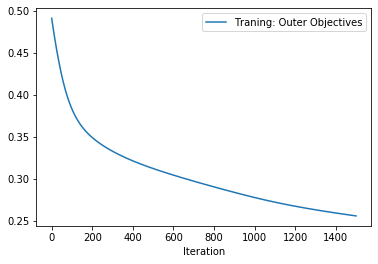

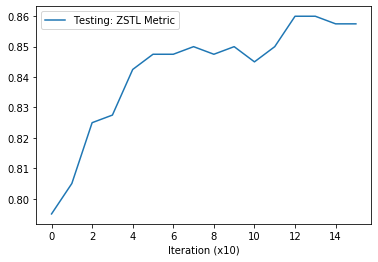

mean metric 0.8574999999999999
rho for w_kb 1e-05; mu for a_kb 0.01;
softmax selected
test  torch.Size([5, 20]) torch.Size([8, 20]) torch.Size([20, 20, 8]) torch.Size([20, 20, 1])
weight_kb  torch.Size([8, 10])
init mean test metric 0.7949999999999999; align loss 0.5044783353805542
1/1500 o_loss 0.49099932513587796; m train metric 0.8166666666666663; m test metric 0.7949999999999999; align loss  0.013318121433258057
100/1500 o_loss 0.3834181564277969; m train metric 0.8329166666666671; m test metric 0.8049999999999999; align loss  0.009750545024871826
200/1500 o_loss 0.3491908621508628; m train metric 0.8508333333333336; m test metric 0.8249999999999998; align loss  0.008850127458572388
300/1500 o_loss 0.33281007321784273; m train metric 0.8575000000000002; m test metric 0.8275; align loss  0.008850723505020142
400/1500 o_loss 0.3213062008066724; m train metric 0.8625000000000002; m test metric 0.8424999999999999; align loss  0.009040772914886475
500/1500 o_loss 0.31219389392451075; m 

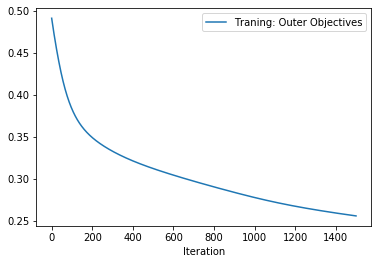

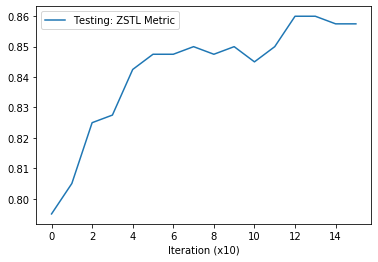

mean metric 0.8574999999999999
rho for w_kb 1e-05; mu for a_kb 0.001;
softmax selected
test  torch.Size([5, 20]) torch.Size([8, 20]) torch.Size([20, 20, 8]) torch.Size([20, 20, 1])
weight_kb  torch.Size([8, 10])
init mean test metric 0.795; align loss 0.06233779340982437
1/1500 o_loss 0.49099932513587796; m train metric 0.8166666666666668; m test metric 0.795; align loss  0.013249356299638748
100/1500 o_loss 0.38341815853879474; m train metric 0.8329166666666669; m test metric 0.805; align loss  0.009682949632406235
200/1500 o_loss 0.3491908630821854; m train metric 0.8508333333333337; m test metric 0.825; align loss  0.00878390297293663
300/1500 o_loss 0.3328100673776741; m train metric 0.8575000000000004; m test metric 0.8275; align loss  0.008785653859376907
400/1500 o_loss 0.32130619161762297; m train metric 0.8625000000000003; m test metric 0.8424999999999999; align loss  0.008976690471172333
500/1500 o_loss 0.31219388120031605; m train metric 0.8641666666666666; m test metric 0.8

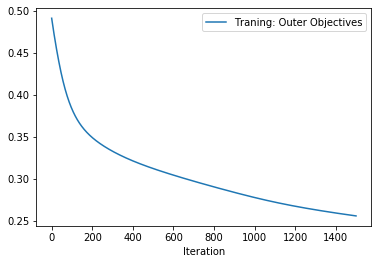

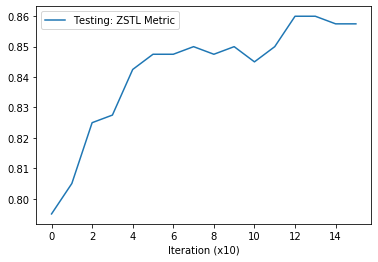

mean metric 0.8574999999999999
rho for w_kb 1e-05; mu for a_kb 0.0001;
softmax selected
test  torch.Size([5, 20]) torch.Size([8, 20]) torch.Size([20, 20, 8]) torch.Size([20, 20, 1])
weight_kb  torch.Size([8, 10])
init mean test metric 0.795; align loss 0.01812373846769333
1/1500 o_loss 0.49099932513587796; m train metric 0.8166666666666669; m test metric 0.795; align loss  0.013242481276392937
100/1500 o_loss 0.3834181652443173; m train metric 0.8329166666666671; m test metric 0.805; align loss  0.009676199406385422
200/1500 o_loss 0.3491908466288199; m train metric 0.8508333333333337; m test metric 0.825; align loss  0.008777296170592308
300/1500 o_loss 0.33281001790504283; m train metric 0.8575000000000004; m test metric 0.8275; align loss  0.008779157884418964
400/1500 o_loss 0.3213061200377221; m train metric 0.8624999999999999; m test metric 0.8425; align loss  0.008970305323600769
500/1500 o_loss 0.312193770306961; m train metric 0.864166666666667; m test metric 0.847499999999999

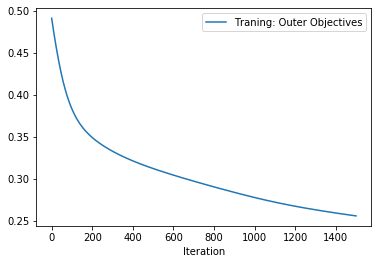

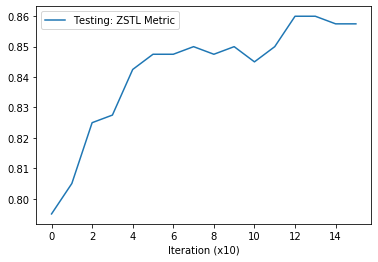

mean metric 0.8574999999999997
rho for w_kb 1e-05; mu for a_kb 1e-05;
softmax selected
test  torch.Size([5, 20]) torch.Size([8, 20]) torch.Size([20, 20, 8]) torch.Size([20, 20, 1])
weight_kb  torch.Size([8, 10])
init mean test metric 0.7949999999999999; align loss 0.013702332973480225
1/1500 o_loss 0.49099932513587796; m train metric 0.8166666666666669; m test metric 0.7949999999999999; align loss  0.01324179396033287
100/1500 o_loss 0.38341829190418747; m train metric 0.832916666666667; m test metric 0.8049999999999999; align loss  0.009675583802163601
200/1500 o_loss 0.34919068110175433; m train metric 0.8508333333333334; m test metric 0.8249999999999998; align loss  0.008776760660111904
300/1500 o_loss 0.33280958941904826; m train metric 0.8575000000000004; m test metric 0.8274999999999999; align loss  0.008778681047260761
400/1500 o_loss 0.3213054024265148; m train metric 0.8625000000000002; m test metric 0.8424999999999999; align loss  0.00896986573934555
500/1500 o_loss 0.3121927

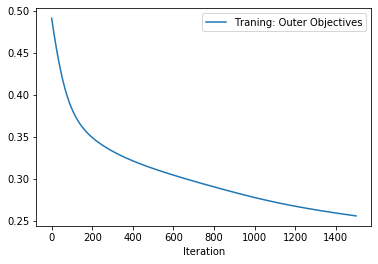

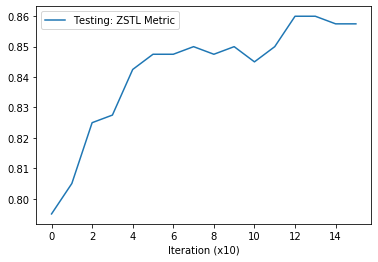

mean metric 0.8574999999999999
best_hp  {'mu': 0.0001, 'rho': 0.0001}


In [7]:
support_a, support_w, support_x, support_y = next(iter(support_loader))
support_a, support_w, support_x, support_y = support_a.float(), support_w.float(), support_x.float(), support_y.float()
support_a = support_a.squeeze().t()
support_w = support_w.squeeze().t()
dm = support_a.size()[0]
print(dm)
d  = support_w.size()[0]
print(d)


indx = train_indx
val_indx = list(np.random.choice(indx, size=20, replace=False))
print(len(val_indx))
train_indx_splited = [x for x in indx if x not in val_indx]
print(len(train_indx_splited))

val_data = utils.Dataset([dataset[d] for d in val_indx])
train_splited_data = utils.Dataset([dataset[d] for d in train_indx_splited])
val_loader = DataLoader(val_data, batch_size=len(val_indx), shuffle=True)
train_splited_loader = DataLoader(train_splited_data, batch_size=len(train_indx_splited), shuffle=True)

best_hp = utils.hp_select_binClass(train_splited_loader, val_loader, support_loader, d, dm, net, shape_record, device)
print('best_hp ', best_hp)

5
{'rho': 0.0001, 'mu': 0.0001, 'loss': 'binary class', 'outer lr': 0.001, 'align lr': 0.0001, 'dm': 5, 'd': 8, 'model_shape': {0: [(1, 8)]}, 'atten_activation': 'Sparsemax'}
test  torch.Size([5, 50]) torch.Size([8, 50]) torch.Size([50, 20, 8]) torch.Size([50, 20, 1])
weight_kb  torch.Size([8, 10])
init mean test metric 0.8100000000000002; align loss 0.017464643344283104
1/1800 o_loss 0.499125989127372; m train metric 0.8135714285714281; m test metric 0.8100000000000002; align loss  0.012629438191652298
100/1800 o_loss 0.3462151980692787; m train metric 0.8621428571428575; m test metric 0.8479999999999996; align loss  0.009827492758631706
200/1800 o_loss 0.31358190146940096; m train metric 0.873571428571429; m test metric 0.8659999999999997; align loss  0.009449634701013565
300/1800 o_loss 0.2929614983232958; m train metric 0.8771428571428581; m test metric 0.8729999999999998; align loss  0.00932344514876604
400/1800 o_loss 0.280231706039714; m train metric 0.8842857142857152; m test m

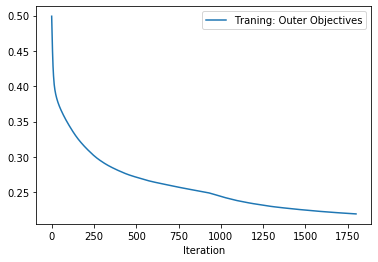

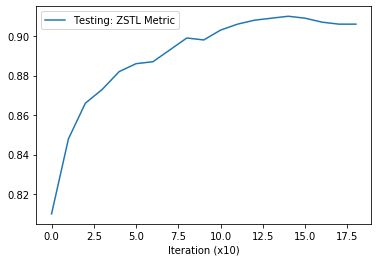

0

In [8]:
support_a, support_w, support_x, support_y = next(iter(support_loader))
support_a, support_w, support_x, support_y = support_a.float(), support_w.float(), support_x.float(), support_y.float()
support_a = support_a.squeeze().t()
support_w = support_w.squeeze().t()
dm = support_a.size()[0]
print(dm)

param_dict = {}
param_dict['rho'] = best_hp['rho']
param_dict['mu'] = best_hp['mu']
param_dict['loss'] = 'binary class'
param_dict['outer lr'] = 1e-3
param_dict['align lr'] = 1e-4
param_dict['dm'] = dm
param_dict['d'] = d
param_dict['model_shape'] = shape_record
param_dict['atten_activation'] = 'Sparsemax'
print(param_dict)


ZSTL_model = ZSTL(support_w, support_a, net, param_dict, device)
ZSTL_model.train(train_loader, test_loader, max_iter=1800)


In [9]:
def genSplits(dataset, train_size, test_size, support_size, T, train_batch_size=140):
    indx = [ x for x in range(len(dataset))]
    support_indx = list(np.random.choice(indx, size=kb_size, replace=False))
    print(len(support_indx))
    temp = [x for x in indx if x not in support_indx]
    train_indx = list(np.random.choice(temp, size=train_size, replace=False))
    temp = [x for x in temp if x not in train_indx]
    print(len(train_indx))
    test_indx = temp
    print(len(test_indx))


    support_data = utils.Dataset([dataset[d] for d in support_indx])
    train_data = utils.Dataset([dataset[d] for d in train_indx])
    test_data = utils.Dataset([dataset[d] for d in test_indx])

    support_loader = DataLoader(support_data, batch_size=kb_size, shuffle=False)
    train_loader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=test_size, shuffle=True)

    return support_loader, train_loader, test_loader

train_size1 = 140
test_size1 = 50
support_size1 = 10
support_loader, train_loader, test_loader = genSplits(dataset, train_size1, test_size1, support_size1, T, train_batch_size=train_size1)

10
140
50


{'rho': 0.0001, 'mu': 0.0001, 'loss': 'binary class', 'outer lr': 0.001, 'align lr': 0.0001, 'dm': 5, 'd': 8, 'model_shape': {0: [(1, 8)]}, 'atten_activation': 'Sparsemax'}
10
140
50
test  torch.Size([5, 50]) torch.Size([8, 50]) torch.Size([50, 20, 8]) torch.Size([50, 20, 1])
weight_kb  torch.Size([8, 10])
init mean test metric 0.7819999999999999; align loss 0.01836194097995758
1/1800 o_loss 0.45223200910591654; m train metric 0.8107142857142858; m test metric 0.7829999999999999; align loss  0.01579664833843708
100/1800 o_loss 0.3451630079054407; m train metric 0.8628571428571435; m test metric 0.8340000000000001; align loss  0.007167931646108627
200/1800 o_loss 0.3149027682042548; m train metric 0.8700000000000003; m test metric 0.8519999999999999; align loss  0.007163650821894407
300/1800 o_loss 0.2992188973352313; m train metric 0.8746428571428577; m test metric 0.8599999999999999; align loss  0.0073673902079463005
400/1800 o_loss 0.28921057637780906; m train metric 0.88000000000000

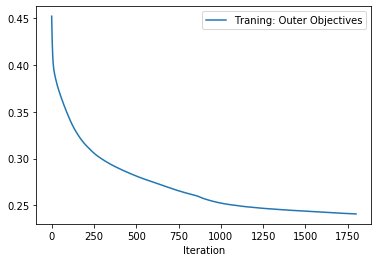

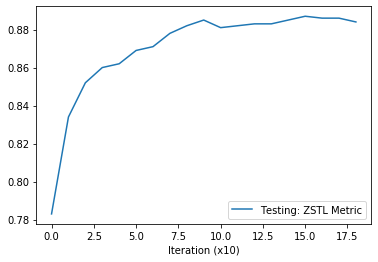

mean acc  tensor(0.8840, dtype=torch.float64)
10
140
50
test  torch.Size([5, 50]) torch.Size([8, 50]) torch.Size([50, 20, 8]) torch.Size([50, 20, 1])
weight_kb  torch.Size([8, 10])
init mean test metric 0.8079999999999999; align loss 0.028288565576076508
1/1800 o_loss 0.6394752651186926; m train metric 0.8025; m test metric 0.8079999999999999; align loss  0.025094354525208473
100/1800 o_loss 0.3862452467637403; m train metric 0.8585714285714291; m test metric 0.8449999999999999; align loss  0.025054793804883957
200/1800 o_loss 0.3493632514828018; m train metric 0.8671428571428577; m test metric 0.8569999999999999; align loss  0.02350940927863121
300/1800 o_loss 0.32386721886162245; m train metric 0.8757142857142857; m test metric 0.8620000000000002; align loss  0.02201915718615055
400/1800 o_loss 0.30830219755215305; m train metric 0.8775000000000004; m test metric 0.8690000000000001; align loss  0.02121816948056221
500/1800 o_loss 0.2980922593602112; m train metric 0.8832142857142861;

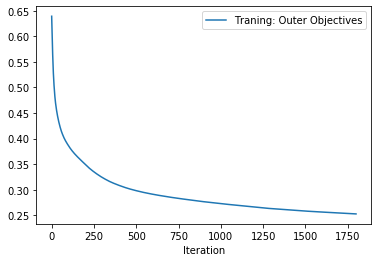

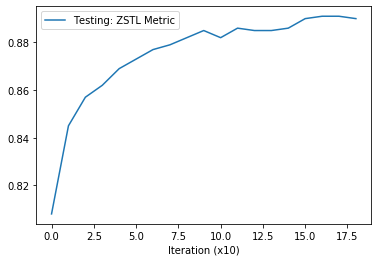

mean acc  tensor(0.8900, dtype=torch.float64)
10
140
50
test  torch.Size([5, 50]) torch.Size([8, 50]) torch.Size([50, 20, 8]) torch.Size([50, 20, 1])
weight_kb  torch.Size([8, 10])
init mean test metric 0.8240000000000001; align loss 0.03077606111764908
1/1800 o_loss 0.5653514650650322; m train metric 0.8074999999999997; m test metric 0.8240000000000001; align loss  0.026829838752746582
100/1800 o_loss 0.35661986663139295; m train metric 0.841071428571429; m test metric 0.8520000000000003; align loss  0.02448466792702675
200/1800 o_loss 0.33062245312279886; m train metric 0.8578571428571431; m test metric 0.8770000000000002; align loss  0.024065665900707245
300/1800 o_loss 0.3149198512413672; m train metric 0.8692857142857149; m test metric 0.8809999999999999; align loss  0.02390565350651741
400/1800 o_loss 0.303027948683926; m train metric 0.8796428571428574; m test metric 0.8819999999999998; align loss  0.02363090217113495
500/1800 o_loss 0.29374243559847985; m train metric 0.8846428

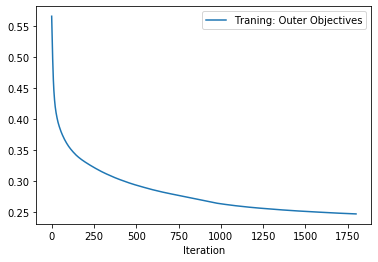

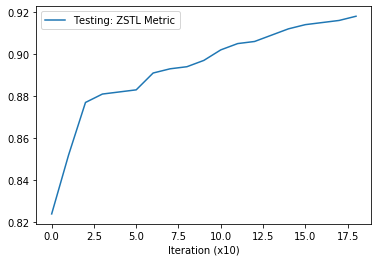

mean acc  tensor(0.9180, dtype=torch.float64)
10
140
50
test  torch.Size([5, 50]) torch.Size([8, 50]) torch.Size([50, 20, 8]) torch.Size([50, 20, 1])
weight_kb  torch.Size([8, 10])
init mean test metric 0.7549999999999999; align loss 0.00898045301437378
1/1800 o_loss 0.5940381563534695; m train metric 0.728571428571429; m test metric 0.7549999999999999; align loss  0.007145782932639122
100/1800 o_loss 0.4035718701380704; m train metric 0.8271428571428577; m test metric 0.8270000000000003; align loss  0.005343637429177761
200/1800 o_loss 0.3675566205089646; m train metric 0.8450000000000003; m test metric 0.8470000000000003; align loss  0.005645724479109049
300/1800 o_loss 0.3439042544258492; m train metric 0.8539285714285723; m test metric 0.8500000000000003; align loss  0.006196044385433197
400/1800 o_loss 0.32712832363322375; m train metric 0.8600000000000003; m test metric 0.8600000000000003; align loss  0.006964288651943207
500/1800 o_loss 0.31561328096847446; m train metric 0.8646

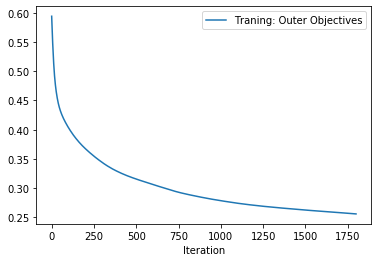

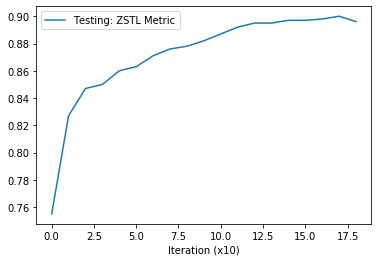

mean acc  tensor(0.8960, dtype=torch.float64)
10
140
50
test  torch.Size([5, 50]) torch.Size([8, 50]) torch.Size([50, 20, 8]) torch.Size([50, 20, 1])
weight_kb  torch.Size([8, 10])
init mean test metric 0.7609999999999999; align loss 0.03652061149477959
1/1800 o_loss 0.5992264329987977; m train metric 0.7935714285714285; m test metric 0.7609999999999999; align loss  0.036091241985559464
100/1800 o_loss 0.3973325283133558; m train metric 0.8450000000000008; m test metric 0.8240000000000001; align loss  0.03157557547092438
200/1800 o_loss 0.3611022693105042; m train metric 0.8585714285714291; m test metric 0.8440000000000001; align loss  0.03139587119221687
300/1800 o_loss 0.33847160138455884; m train metric 0.8650000000000008; m test metric 0.862; align loss  0.03124459646642208
400/1800 o_loss 0.32022655344169054; m train metric 0.8703571428571432; m test metric 0.8810000000000001; align loss  0.03096708655357361
500/1800 o_loss 0.30686120241880416; m train metric 0.873928571428572; m 

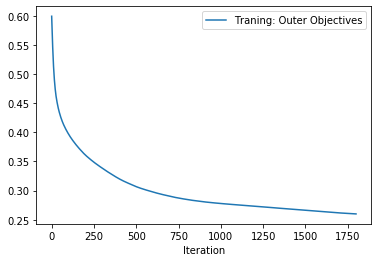

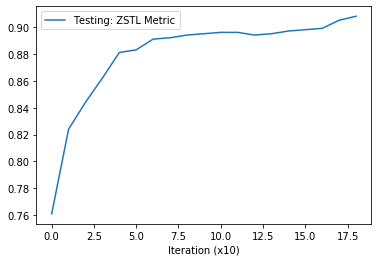

mean acc  tensor(0.9080, dtype=torch.float64)
10
140
50
test  torch.Size([5, 50]) torch.Size([8, 50]) torch.Size([50, 20, 8]) torch.Size([50, 20, 1])
weight_kb  torch.Size([8, 10])
init mean test metric 0.7389999999999999; align loss 0.029945826157927513
1/1800 o_loss 0.6223737073263952; m train metric 0.799642857142857; m test metric 0.7389999999999999; align loss  0.02389334887266159
100/1800 o_loss 0.41332517175802164; m train metric 0.8403571428571434; m test metric 0.7890000000000001; align loss  0.020740212872624397
200/1800 o_loss 0.3684028353275997; m train metric 0.857500000000001; m test metric 0.8030000000000002; align loss  0.02167043648660183
300/1800 o_loss 0.33229125275143556; m train metric 0.8667857142857149; m test metric 0.8180000000000001; align loss  0.023628121241927147
400/1800 o_loss 0.3077046453420605; m train metric 0.8771428571428581; m test metric 0.8290000000000002; align loss  0.02635989896953106
500/1800 o_loss 0.28910286040710553; m train metric 0.884285

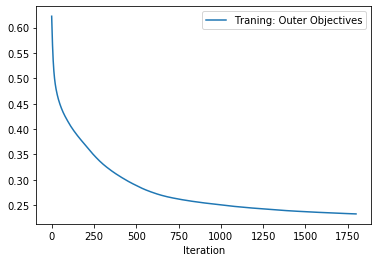

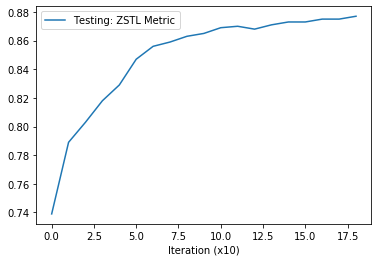

mean acc  tensor(0.8770, dtype=torch.float64)
10
140
50
test  torch.Size([5, 50]) torch.Size([8, 50]) torch.Size([50, 20, 8]) torch.Size([50, 20, 1])
weight_kb  torch.Size([8, 10])
init mean test metric 0.8170000000000001; align loss 0.03136201575398445
1/1800 o_loss 0.5604168334842793; m train metric 0.8089285714285712; m test metric 0.8170000000000001; align loss  0.02400500699877739
100/1800 o_loss 0.372362615088267; m train metric 0.840357142857143; m test metric 0.8440000000000002; align loss  0.01973068341612816
200/1800 o_loss 0.3440570409276656; m train metric 0.8492857142857145; m test metric 0.8480000000000001; align loss  0.018487609922885895
300/1800 o_loss 0.32586520336834446; m train metric 0.8521428571428574; m test metric 0.8539999999999999; align loss  0.017621023580431938
400/1800 o_loss 0.31180182131273404; m train metric 0.8614285714285717; m test metric 0.8540000000000002; align loss  0.01687673106789589
500/1800 o_loss 0.3001168533228338; m train metric 0.86785714

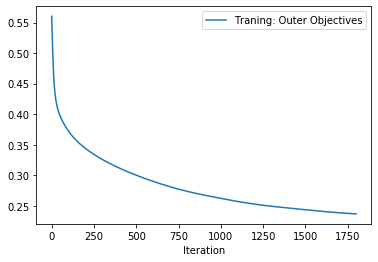

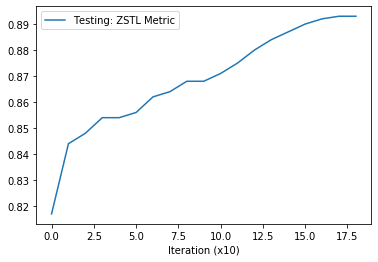

mean acc  tensor(0.8930, dtype=torch.float64)
10
140
50
test  torch.Size([5, 50]) torch.Size([8, 50]) torch.Size([50, 20, 8]) torch.Size([50, 20, 1])
weight_kb  torch.Size([8, 10])
init mean test metric 0.8219999999999998; align loss 0.01514407992362976
1/1800 o_loss 0.6267356949991414; m train metric 0.8042857142857145; m test metric 0.8219999999999998; align loss  0.010619476437568665
100/1800 o_loss 0.44766586372362716; m train metric 0.8285714285714288; m test metric 0.8329999999999999; align loss  0.007146947085857391
200/1800 o_loss 0.3916144690609404; m train metric 0.846071428571429; m test metric 0.8580000000000001; align loss  0.006653083022683859
300/1800 o_loss 0.359744596148708; m train metric 0.8578571428571432; m test metric 0.8630000000000001; align loss  0.006502670235931873
400/1800 o_loss 0.3377464335411787; m train metric 0.8682142857142859; m test metric 0.8740000000000002; align loss  0.0066057839430868626
500/1800 o_loss 0.32199225473616805; m train metric 0.8739

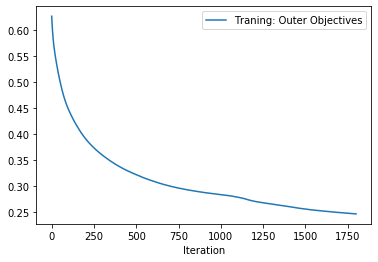

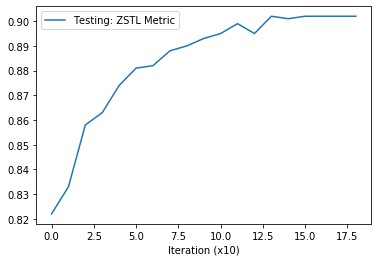

mean acc  tensor(0.9020, dtype=torch.float64)
10
140
50
test  torch.Size([5, 50]) torch.Size([8, 50]) torch.Size([50, 20, 8]) torch.Size([50, 20, 1])
weight_kb  torch.Size([8, 10])
init mean test metric 0.8070000000000002; align loss 0.01959197223186493
1/1800 o_loss 0.5239943335897156; m train metric 0.8096428571428569; m test metric 0.8070000000000002; align loss  0.01740235835313797
100/1800 o_loss 0.3669326200549092; m train metric 0.835714285714286; m test metric 0.8290000000000001; align loss  0.015013940632343292
200/1800 o_loss 0.3320356773079506; m train metric 0.8632142857142862; m test metric 0.8540000000000002; align loss  0.015123664401471615
300/1800 o_loss 0.3076225028772439; m train metric 0.876071428571429; m test metric 0.8610000000000001; align loss  0.015130255371332169
400/1800 o_loss 0.2915306897434805; m train metric 0.8835714285714292; m test metric 0.8669999999999999; align loss  0.015249209478497505
500/1800 o_loss 0.28079057315896666; m train metric 0.8932142

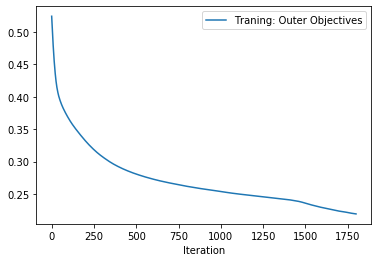

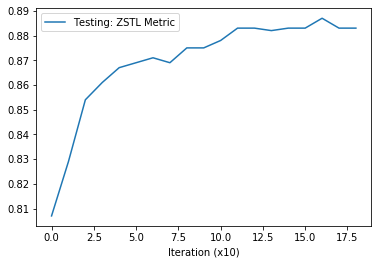

mean acc  tensor(0.8830, dtype=torch.float64)
10
140
50
test  torch.Size([5, 50]) torch.Size([8, 50]) torch.Size([50, 20, 8]) torch.Size([50, 20, 1])
weight_kb  torch.Size([8, 10])
init mean test metric 0.7789999999999999; align loss 0.010699893347918987
1/1800 o_loss 0.5398263432617698; m train metric 0.7535714285714287; m test metric 0.7789999999999999; align loss  0.007088994607329369
100/1800 o_loss 0.4023338440805674; m train metric 0.8371428571428569; m test metric 0.8400000000000002; align loss  0.0063287438824772835
200/1800 o_loss 0.36301416491291355; m train metric 0.8485714285714288; m test metric 0.8420000000000002; align loss  0.0063570355996489525
300/1800 o_loss 0.33670869627967476; m train metric 0.8575000000000002; m test metric 0.8539999999999999; align loss  0.006726066581904888
400/1800 o_loss 0.31533769845430343; m train metric 0.8689285714285718; m test metric 0.8560000000000001; align loss  0.007473305333405733
500/1800 o_loss 0.30170470041089825; m train metric 

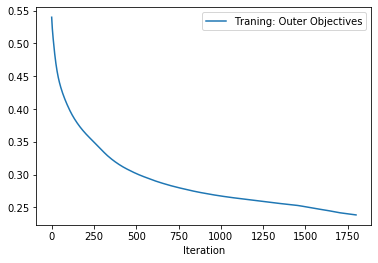

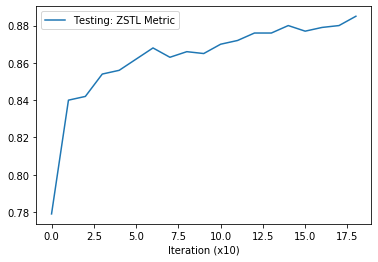

mean acc  tensor(0.8850, dtype=torch.float64)


In [10]:
exp_results = []
Run = 10
print(param_dict)
for r in range(Run):
    support_loader, train_loader, test_loader = genSplits(dataset, train_size1, test_size1, support_size1, T, train_batch_size=train_size1)
    support_a, support_w, support_x, support_y = next(iter(support_loader))
    support_a, support_w, support_x, support_y = support_a.float(), support_w.float(), support_x.float(), support_y.float()
    support_a = support_a.squeeze().t()
    support_w = support_w.squeeze().t()
    ZSTL_model = ZSTL(support_w, support_a,  net, param_dict, device)
    ZSTL_model.train(train_loader, test_loader, max_iter=1800)
    mean_acc = ZSTL_model.zero_shot_transfer(test_loader)
    print('mean acc ', mean_acc)
    exp_results.append(utils.toNumpy(mean_acc))


In [11]:
import scipy
from scipy import stats
print(exp_results)
sample = np.array(exp_results)
confidence_level = 0.95
degrees_freedom = sample.size - 1
sample_mean = np.mean(sample)
sample_standard_error = scipy.stats.sem(sample)

confidence_interval = stats.t.interval(confidence_level, degrees_freedom, sample_mean, sample_standard_error)
print(sample_mean)
print(confidence_interval)
print(confidence_interval - sample_mean)

[array(0.884), array(0.89), array(0.918), array(0.896), array(0.908), array(0.877), array(0.893), array(0.902), array(0.883), array(0.885)]
0.8936
(0.8845312855781481, 0.9026687144218518)
[-0.00906871  0.00906871]


In [12]:
print(param_dict)

{'rho': 0.0001, 'mu': 0.0001, 'loss': 'binary class', 'outer lr': 0.001, 'align lr': 0.0001, 'dm': 5, 'd': 8, 'model_shape': {0: [(1, 8)]}, 'atten_activation': 'Sparsemax'}
